<a href="https://colab.research.google.com/github/seenu-g/school_of_ai/blob/master/chap6/trail2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


**Model**

In [0]:
dropout_value = 0.03
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layer1 = nn.Sequential(                      
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=True),#Op_size = 26, RF = 3
            nn.ReLU(),
            nn.BatchNorm2d(num_features=12),
            nn.Dropout2d(dropout_value)
        )
        self.conv_layer2 = nn.Sequential(  
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=True),#Op_size = 24, RF = 5
            nn.ReLU(),
            nn.BatchNorm2d(num_features=12),
            nn.Dropout2d(dropout_value)
        )
        self.maxpool_layer1 = nn.MaxPool2d(kernel_size=(2,2)) #Op_size = 12, RF = 6
        self.conv_layer3 = nn.Sequential(  
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=True), #Op_size = 10, RF = 10   
            nn.ReLU(),
            nn.BatchNorm2d(num_features=14),
            nn.Dropout2d(dropout_value)
        )
        self.conv_layer4 = nn.Sequential(  
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=True), #Op_size = 8, RF = 14
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            nn.Dropout2d(dropout_value) 
        )
        self.conv_layer5 = nn.Sequential(  
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=True),#Op_size = 6, RF = 18 
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            nn.Dropout(dropout_value)
        )
        self.conv_layer6 = nn.Sequential(  
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=True),#Op_size = 6, RF = 22 
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            nn.Dropout(dropout_value)
        )            
        self.avgpool_layer1 = nn.AvgPool2d(kernel_size=6)

        self.conv_layer7 = nn.Sequential(  
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=True)#Op_size = 1, RF = 28
        )

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x =  self.maxpool_layer1(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = self.conv_layer5(x)
        x = self.conv_layer6(x)
        x = self.avgpool_layer1(x)
        x = self.conv_layer7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

*italicized text*# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1,28,28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
         Dropout2d-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,308
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
         Dropout2d-8           [-1, 12, 24, 24]               0
         MaxPool2d-9           [-1, 12, 12, 12]               0
           Conv2d-10           [-1, 14, 10, 10]           1,526
             ReLU-11           [-1, 14, 10, 10]               0
      BatchNorm2d-12           [-1, 14, 10, 10]              28
        Dropout2d-13           [-1, 14, 10, 10]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
def L1_Loss(model, data, factor=0.0005):
  l1_crit = nn.L1Loss().to(device)
  reg_loss = 0
  
  for param in model.parameters():
    zero_vector = torch.rand_like(param) * 0
    reg_loss += l1_crit(param, zero_vector)

  
  return factor * reg_loss

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch,isL1=False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    #CAlculate L1 loss
    if(isL1==True):
      loss += L1_Loss(model,data,factor=0.0005)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Epoch={epoch} Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader,test_losses, test_acc, misclassified):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            for i in range(len(pred)):
              if pred[i]!= target[i]:
                misclassified.append([data[i], pred[i], target[i]])
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_test_loss_acc(test_losses,test_acc):
  fig, axs = plt.subplots(1,2,figsize=(15,10))
  axs[0].plot(test_losses)
  axs[0].set_title("Test Loss")
  axs[1].plot(test_acc)
  axs[1].set_title("Test Accuracy")

In [0]:
def plot_misclassified(misclassified):
  fig = plt.figure(figsize = (10,10))
  for i in range(25):
        sub = fig.add_subplot(5, 5, i+1)
        plt.imshow(misclassified[i][0].cpu().numpy().squeeze(),cmap='gray',interpolation='none')
        
        sub.set_title("Pred={}, Act={}".format(str(misclassified[i][1].data.cpu().numpy()),str(misclassified[i][2].data.cpu().numpy())))
        
  plt.tight_layout()

  plt.show()

In [0]:
def without_L1L2():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  EPOCHS = 4
  for epoch in range(EPOCHS):
     print("EPOCH:", epoch)
     train(model, device, train_loader, optimizer, epoch, False)
     test(model, device, test_loader,test_without_L1L2_Loss, test_without_L1L2_acc,misclassifiedwithoutL1L2)
  
  plot_test_loss_acc(test_without_L1L2_Loss,test_without_L1L2_acc)
  plot_misclassified(misclassifiedwithoutL1L2)

In [0]:
def with_L1():
    
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

  #scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
  EPOCHS = 4
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, True)
      test(model, device, test_loader,test_with_L1_Loss, test_with_L1_acc,misclassifiedL1)

  plot_test_loss_acc(test_with_L1_Loss, test_with_L1_acc)
  plot_misclassified(misclassifiedL1)

In [0]:
def with_L2():
    
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

  #scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
  EPOCHS = 4
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, False)
      test(model, device, test_loader,test_with_L2_Loss, test_with_L2_acc,misclassifiedL2)

  plot_test_loss_acc(test_with_L2_Loss,test_with_L2_acc)
  plot_misclassified(misclassifiedL2)

In [0]:
def with_L1_L2():
    
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

  #scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
  EPOCHS = 4
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, True)
      test(model, device, test_loader,test_with_L1L2_Loss, test_with_L1L2_acc,misclassifiedL1L2)

  plot_test_loss_acc(test_with_L1L2_Loss,test_with_L1L2_acc)
  plot_misclassified(misclassifiedL1L2)

In [0]:
test_without_L1L2_Loss = []
test_without_L1L2_acc = []
misclassifiedwithoutL1L2= []

test_with_L1_Loss = []
test_with_L1_acc = []
misclassifiedL1 = []

test_with_L2_Loss = []
test_with_L2_acc = []
misclassifiedL2 = []

test_with_L1L2_Loss = []
test_with_L1L2_acc = []
misclassifiedL1L2 = []

from torch.optim.lr_scheduler import StepLR

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Epoch=0 Loss=0.11136364936828613 Batch_id=468 Accuracy=87.92: 100%|██████████| 469/469 [00:10<00:00, 44.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0653, Accuracy: 9835/10000 (98.35%)

EPOCH: 1


Epoch=1 Loss=0.022386765107512474 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:11<00:00, 42.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0394, Accuracy: 9888/10000 (98.88%)

EPOCH: 2


Epoch=2 Loss=0.05815628170967102 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:10<00:00, 44.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Accuracy: 9888/10000 (98.88%)

EPOCH: 3


Epoch=3 Loss=0.02352009527385235 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:10<00:00, 44.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9912/10000 (99.12%)

EPOCH: 4


Epoch=4 Loss=0.01933559589087963 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:11<00:00, 41.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9921/10000 (99.21%)

EPOCH: 5


Epoch=5 Loss=0.04460862651467323 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:11<00:00, 42.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9919/10000 (99.19%)

EPOCH: 6


Epoch=6 Loss=0.017203571274876595 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:11<00:00, 50.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9922/10000 (99.22%)

EPOCH: 7


Epoch=7 Loss=0.016293004155158997 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:10<00:00, 44.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9922/10000 (99.22%)

EPOCH: 8


Epoch=8 Loss=0.027876967564225197 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:10<00:00, 44.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Epoch=9 Loss=0.03225014731287956 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:10<00:00, 44.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Epoch=10 Loss=0.0038407098036259413 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:10<00:00, 43.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9928/10000 (99.28%)

EPOCH: 11


Epoch=11 Loss=0.023787537589669228 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:10<00:00, 43.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9931/10000 (99.31%)

EPOCH: 12


Epoch=12 Loss=0.006427844520658255 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:10<00:00, 43.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Epoch=13 Loss=0.009003912098705769 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:10<00:00, 43.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9936/10000 (99.36%)

EPOCH: 14


Epoch=14 Loss=0.014053478837013245 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:10<00:00, 44.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9933/10000 (99.33%)

EPOCH: 15


Epoch=15 Loss=0.04354527220129967 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:11<00:00, 41.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9930/10000 (99.30%)

EPOCH: 16


Epoch=16 Loss=0.03644222021102905 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:10<00:00, 44.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9932/10000 (99.32%)

EPOCH: 17


Epoch=17 Loss=0.019271666184067726 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:10<00:00, 44.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9940/10000 (99.40%)

EPOCH: 18


Epoch=18 Loss=0.0058823623694479465 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:10<00:00, 43.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9936/10000 (99.36%)

EPOCH: 19


Epoch=19 Loss=0.021757125854492188 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:10<00:00, 44.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9937/10000 (99.37%)

EPOCH: 20


Epoch=20 Loss=0.0069453963078558445 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:11<00:00, 42.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9941/10000 (99.41%)

EPOCH: 21


Epoch=21 Loss=0.04227351024746895 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:10<00:00, 44.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9942/10000 (99.42%)

EPOCH: 22


Epoch=22 Loss=0.014057804830372334 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:10<00:00, 44.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9941/10000 (99.41%)

EPOCH: 23


Epoch=23 Loss=0.007061739917844534 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:11<00:00, 41.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9938/10000 (99.38%)

EPOCH: 24


Epoch=24 Loss=0.005726670380681753 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:10<00:00, 43.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9946/10000 (99.46%)

EPOCH: 25


Epoch=25 Loss=0.011513407342135906 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:11<00:00, 51.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9934/10000 (99.34%)

EPOCH: 26


Epoch=26 Loss=0.017114803194999695 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:10<00:00, 44.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99.40%)

EPOCH: 27


Epoch=27 Loss=0.005684837698936462 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:10<00:00, 44.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9940/10000 (99.40%)

EPOCH: 28


Epoch=28 Loss=0.013720070011913776 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:10<00:00, 43.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9943/10000 (99.43%)

EPOCH: 29


Epoch=29 Loss=0.005773147102445364 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:11<00:00, 42.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9942/10000 (99.42%)

EPOCH: 30


Epoch=30 Loss=0.0019168307771906257 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:10<00:00, 44.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99.40%)

EPOCH: 31


Epoch=31 Loss=0.02762007713317871 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:10<00:00, 43.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9940/10000 (99.40%)

EPOCH: 32


Epoch=32 Loss=0.02579544484615326 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:11<00:00, 41.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9942/10000 (99.42%)

EPOCH: 33


Epoch=33 Loss=0.043348804116249084 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:10<00:00, 43.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9945/10000 (99.45%)

EPOCH: 34


Epoch=34 Loss=0.0031541783828288317 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:11<00:00, 40.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9944/10000 (99.44%)

EPOCH: 35


Epoch=35 Loss=0.010501806624233723 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:10<00:00, 42.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9943/10000 (99.43%)

EPOCH: 36


Epoch=36 Loss=0.05511532351374626 Batch_id=468 Accuracy=99.60: 100%|██████████| 469/469 [00:10<00:00, 42.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9947/10000 (99.47%)

EPOCH: 37


Epoch=37 Loss=0.08563607186079025 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:10<00:00, 48.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9943/10000 (99.43%)

EPOCH: 38


Epoch=38 Loss=0.0355236791074276 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:11<00:00, 42.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9943/10000 (99.43%)

EPOCH: 39


Epoch=39 Loss=0.0025363911408931017 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:11<00:00, 41.35it/s]



Test set: Average loss: 0.0192, Accuracy: 9948/10000 (99.48%)



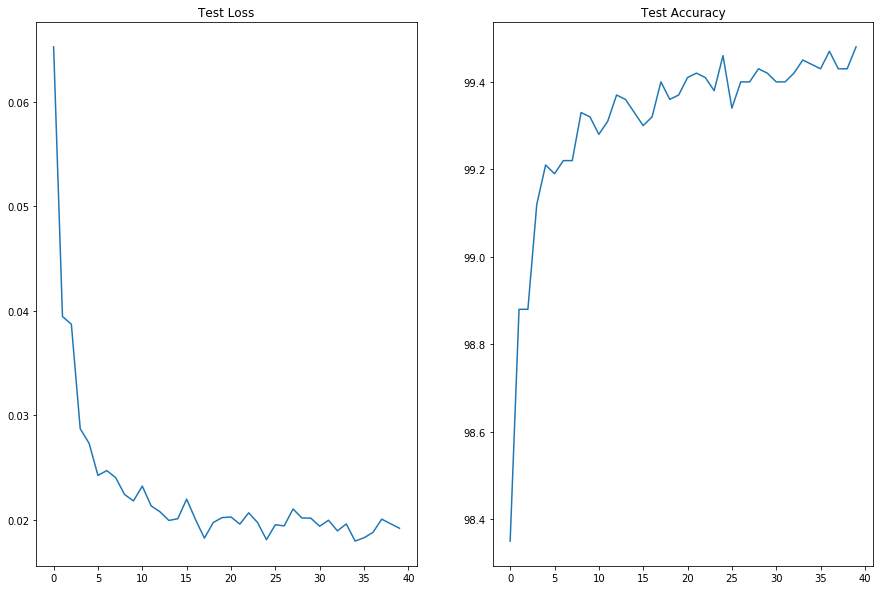

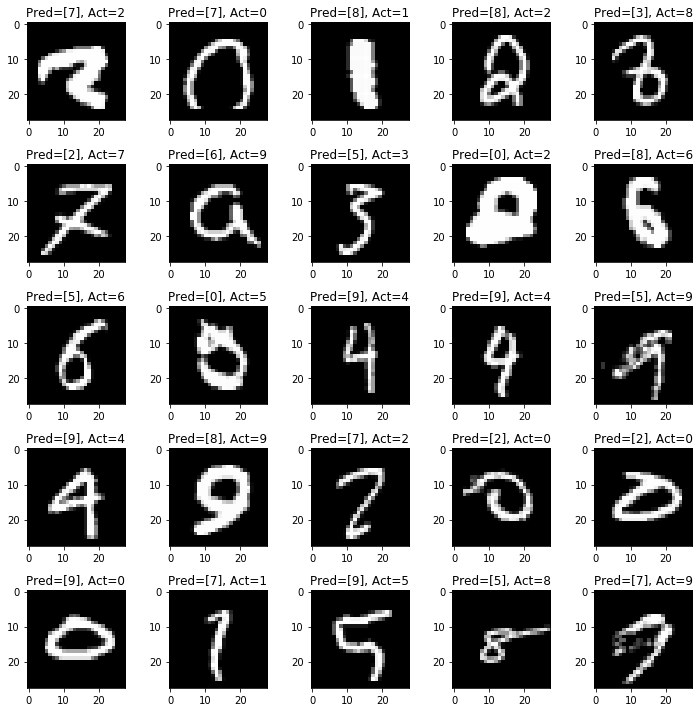

In [0]:
without_L1L2()


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Epoch=0 Loss=0.04286907985806465 Batch_id=468 Accuracy=88.59: 100%|██████████| 469/469 [00:13<00:00, 35.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0784, Accuracy: 9788/10000 (97.88%)

EPOCH: 1


Epoch=1 Loss=0.10398782789707184 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:13<00:00, 35.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9866/10000 (98.66%)

EPOCH: 2


Epoch=2 Loss=0.02383388578891754 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:14<00:00, 33.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9900/10000 (99.00%)

EPOCH: 3


Epoch=3 Loss=0.08055590093135834 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:12<00:00, 42.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9903/10000 (99.03%)

EPOCH: 4


Epoch=4 Loss=0.06375572085380554 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:13<00:00, 35.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9907/10000 (99.07%)

EPOCH: 5


Epoch=5 Loss=0.02307327836751938 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:12<00:00, 36.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9918/10000 (99.18%)

EPOCH: 6


Epoch=6 Loss=0.013305727392435074 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:13<00:00, 43.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9904/10000 (99.04%)

EPOCH: 7


Epoch=7 Loss=0.013279769569635391 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 35.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9919/10000 (99.19%)

EPOCH: 8


Epoch=8 Loss=0.14241042733192444 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:13<00:00, 35.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9928/10000 (99.28%)

EPOCH: 9


Epoch=9 Loss=0.0627346783876419 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:13<00:00, 34.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9936/10000 (99.36%)

EPOCH: 10


Epoch=10 Loss=0.03297024965286255 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:13<00:00, 33.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Epoch=11 Loss=0.014421620406210423 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:13<00:00, 35.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Epoch=12 Loss=0.022349387407302856 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:13<00:00, 44.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9944/10000 (99.44%)

EPOCH: 13


Epoch=13 Loss=0.016246182844042778 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:13<00:00, 35.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9932/10000 (99.32%)

EPOCH: 14


Epoch=14 Loss=0.031252142041921616 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 34.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9931/10000 (99.31%)

EPOCH: 15


Epoch=15 Loss=0.03388667106628418 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:13<00:00, 35.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9940/10000 (99.40%)

EPOCH: 16


Epoch=16 Loss=0.01063581369817257 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:13<00:00, 35.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9931/10000 (99.31%)

EPOCH: 17


Epoch=17 Loss=0.008196596056222916 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:13<00:00, 35.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9938/10000 (99.38%)

EPOCH: 18


Epoch=18 Loss=0.011879486963152885 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:13<00:00, 43.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9935/10000 (99.35%)

EPOCH: 19


Epoch=19 Loss=0.016268469393253326 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:13<00:00, 35.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9929/10000 (99.29%)

EPOCH: 20


Epoch=20 Loss=0.01054616179317236 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:13<00:00, 34.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9940/10000 (99.40%)

EPOCH: 21


Epoch=21 Loss=0.013614706695079803 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:13<00:00, 35.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9935/10000 (99.35%)

EPOCH: 22


Epoch=22 Loss=0.011695964261889458 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:13<00:00, 34.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9941/10000 (99.41%)

EPOCH: 23


Epoch=23 Loss=0.025864338502287865 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:13<00:00, 35.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9942/10000 (99.42%)

EPOCH: 24


Epoch=24 Loss=0.06687292456626892 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:13<00:00, 35.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9942/10000 (99.42%)

EPOCH: 25


Epoch=25 Loss=0.03215748071670532 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:13<00:00, 35.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9946/10000 (99.46%)

EPOCH: 26


Epoch=26 Loss=0.031056825071573257 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:13<00:00, 34.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9939/10000 (99.39%)

EPOCH: 27


Epoch=27 Loss=0.010820422321557999 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:12<00:00, 43.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9937/10000 (99.37%)

EPOCH: 28


Epoch=28 Loss=0.03678275644779205 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:13<00:00, 35.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9929/10000 (99.29%)

EPOCH: 29


Epoch=29 Loss=0.005853332579135895 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:13<00:00, 33.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9936/10000 (99.36%)

EPOCH: 30


Epoch=30 Loss=0.00625682482495904 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:13<00:00, 34.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9929/10000 (99.29%)

EPOCH: 31


Epoch=31 Loss=0.02803531102836132 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:13<00:00, 35.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9938/10000 (99.38%)

EPOCH: 32


Epoch=32 Loss=0.021971313282847404 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:13<00:00, 34.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9943/10000 (99.43%)

EPOCH: 33


Epoch=33 Loss=0.03149803355336189 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:13<00:00, 43.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9934/10000 (99.34%)

EPOCH: 34


Epoch=34 Loss=0.009186017327010632 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:13<00:00, 36.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9946/10000 (99.46%)

EPOCH: 35


Epoch=35 Loss=0.008907929062843323 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:13<00:00, 35.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9939/10000 (99.39%)

EPOCH: 36


Epoch=36 Loss=0.058278173208236694 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:13<00:00, 35.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9936/10000 (99.36%)

EPOCH: 37


Epoch=37 Loss=0.01617848500609398 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:13<00:00, 34.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9942/10000 (99.42%)

EPOCH: 38


Epoch=38 Loss=0.029195379465818405 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:13<00:00, 34.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9933/10000 (99.33%)

EPOCH: 39


Epoch=39 Loss=0.008760593831539154 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:13<00:00, 35.61it/s]



Test set: Average loss: 0.0171, Accuracy: 9941/10000 (99.41%)



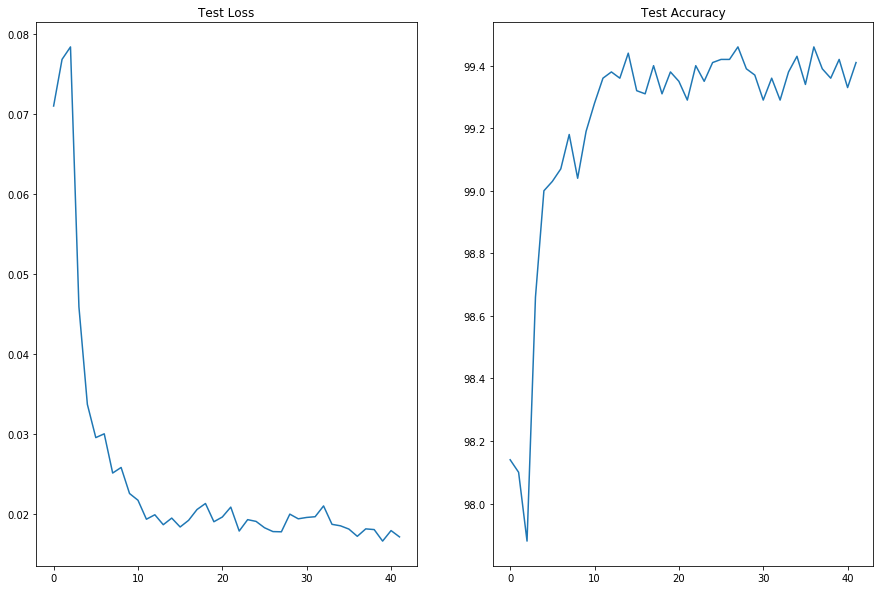

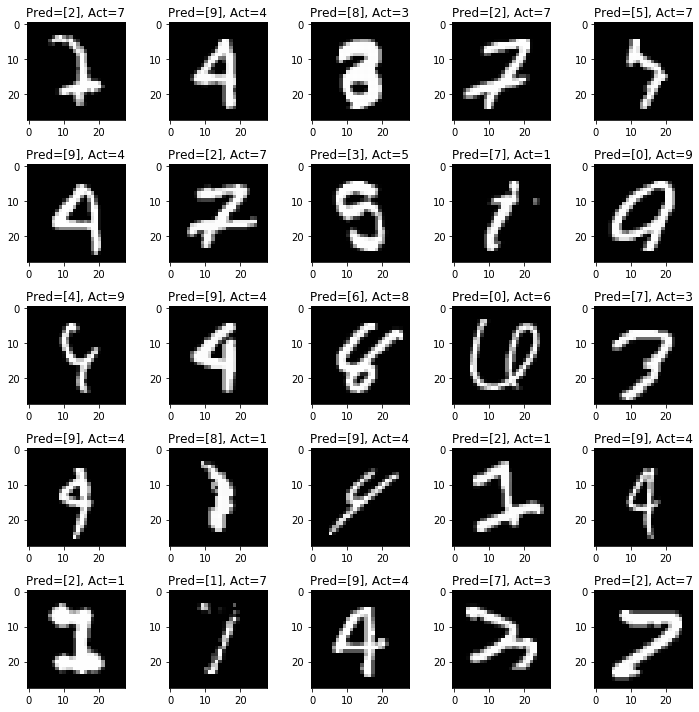

In [0]:
with_L1()

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Epoch=0 Loss=0.1789320856332779 Batch_id=468 Accuracy=88.48: 100%|██████████| 469/469 [00:10<00:00, 50.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0759, Accuracy: 9847/10000 (98.47%)

EPOCH: 1


Epoch=1 Loss=0.051294971257448196 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:10<00:00, 44.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0579, Accuracy: 9868/10000 (98.68%)

EPOCH: 2


Epoch=2 Loss=0.07143602520227432 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:10<00:00, 42.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0548, Accuracy: 9891/10000 (98.91%)

EPOCH: 3


Epoch=3 Loss=0.03745139390230179 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:11<00:00, 41.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0508, Accuracy: 9891/10000 (98.91%)

EPOCH: 4


Epoch=4 Loss=0.05846680700778961 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:11<00:00, 42.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0474, Accuracy: 9895/10000 (98.95%)

EPOCH: 5


Epoch=5 Loss=0.16997842490673065 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:10<00:00, 43.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 9903/10000 (99.03%)

EPOCH: 6


Epoch=6 Loss=0.07366228103637695 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:10<00:00, 43.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9911/10000 (99.11%)

EPOCH: 7


Epoch=7 Loss=0.03466843441128731 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:10<00:00, 43.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0556, Accuracy: 9883/10000 (98.83%)

EPOCH: 8


Epoch=8 Loss=0.0478321798145771 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:11<00:00, 41.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0600, Accuracy: 9879/10000 (98.79%)

EPOCH: 9


Epoch=9 Loss=0.11243949085474014 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:11<00:00, 42.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0533, Accuracy: 9890/10000 (98.90%)

EPOCH: 10


Epoch=10 Loss=0.09012935310602188 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:10<00:00, 43.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1041, Accuracy: 9745/10000 (97.45%)

EPOCH: 11


Epoch=11 Loss=0.10404548794031143 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:10<00:00, 43.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0540, Accuracy: 9893/10000 (98.93%)

EPOCH: 12


Epoch=12 Loss=0.11007943004369736 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:10<00:00, 42.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0611, Accuracy: 9878/10000 (98.78%)

EPOCH: 13


Epoch=13 Loss=0.025058457627892494 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:11<00:00, 52.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0562, Accuracy: 9872/10000 (98.72%)

EPOCH: 14


Epoch=14 Loss=0.07899468392133713 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:10<00:00, 43.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9907/10000 (99.07%)

EPOCH: 15


Epoch=15 Loss=0.07091187685728073 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:10<00:00, 43.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0636, Accuracy: 9865/10000 (98.65%)

EPOCH: 16


Epoch=16 Loss=0.14332954585552216 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:10<00:00, 43.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0517, Accuracy: 9897/10000 (98.97%)

EPOCH: 17


Epoch=17 Loss=0.039741188287734985 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:10<00:00, 43.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0549, Accuracy: 9891/10000 (98.91%)

EPOCH: 18


Epoch=18 Loss=0.09265468269586563 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:11<00:00, 41.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0508, Accuracy: 9904/10000 (99.04%)

EPOCH: 19


Epoch=19 Loss=0.06732090562582016 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:10<00:00, 43.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0498, Accuracy: 9881/10000 (98.81%)

EPOCH: 20


Epoch=20 Loss=0.04950210452079773 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:10<00:00, 51.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9899/10000 (98.99%)

EPOCH: 21


Epoch=21 Loss=0.04729081317782402 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:10<00:00, 43.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0851, Accuracy: 9785/10000 (97.85%)

EPOCH: 22


Epoch=22 Loss=0.06528133898973465 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:10<00:00, 42.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0559, Accuracy: 9876/10000 (98.76%)

EPOCH: 23


Epoch=23 Loss=0.04838724434375763 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:11<00:00, 42.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0828, Accuracy: 9807/10000 (98.07%)

EPOCH: 24


Epoch=24 Loss=0.030860980972647667 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:10<00:00, 44.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9904/10000 (99.04%)

EPOCH: 25


Epoch=25 Loss=0.06703263521194458 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:10<00:00, 43.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0600, Accuracy: 9866/10000 (98.66%)

EPOCH: 26


Epoch=26 Loss=0.06198399141430855 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:10<00:00, 52.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0679, Accuracy: 9842/10000 (98.42%)

EPOCH: 27


Epoch=27 Loss=0.03132129833102226 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:11<00:00, 41.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9919/10000 (99.19%)

EPOCH: 28


Epoch=28 Loss=0.06002737581729889 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:10<00:00, 43.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9903/10000 (99.03%)

EPOCH: 29


Epoch=29 Loss=0.06811142712831497 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:10<00:00, 44.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0593, Accuracy: 9879/10000 (98.79%)

EPOCH: 30


Epoch=30 Loss=0.0326678641140461 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:10<00:00, 43.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0576, Accuracy: 9891/10000 (98.91%)

EPOCH: 31


Epoch=31 Loss=0.08710167557001114 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:10<00:00, 43.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0643, Accuracy: 9846/10000 (98.46%)

EPOCH: 32


Epoch=32 Loss=0.07408125698566437 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:11<00:00, 40.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 9926/10000 (99.26%)

EPOCH: 33


Epoch=33 Loss=0.0344938300549984 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:10<00:00, 42.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0673, Accuracy: 9846/10000 (98.46%)

EPOCH: 34


Epoch=34 Loss=0.05949811637401581 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:10<00:00, 43.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9913/10000 (99.13%)

EPOCH: 35


Epoch=35 Loss=0.13963551819324493 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:10<00:00, 43.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Accuracy: 9908/10000 (99.08%)

EPOCH: 36


Epoch=36 Loss=0.08450683206319809 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:10<00:00, 43.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0508, Accuracy: 9883/10000 (98.83%)

EPOCH: 37


Epoch=37 Loss=0.0487816147506237 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:11<00:00, 41.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0640, Accuracy: 9848/10000 (98.48%)

EPOCH: 38


Epoch=38 Loss=0.029687754809856415 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:10<00:00, 44.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0563, Accuracy: 9878/10000 (98.78%)

EPOCH: 39


Epoch=39 Loss=0.11096193641424179 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:10<00:00, 44.27it/s]



Test set: Average loss: 0.1334, Accuracy: 9621/10000 (96.21%)



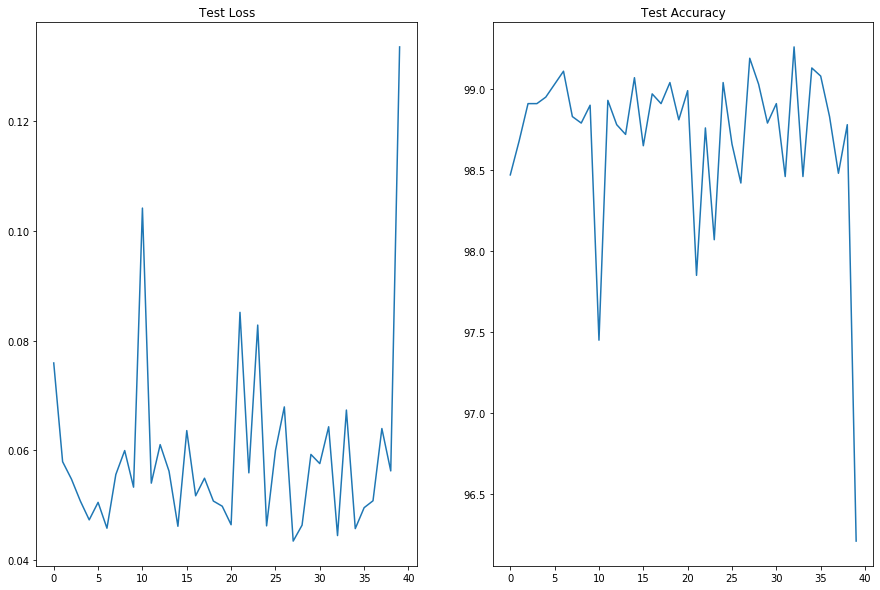

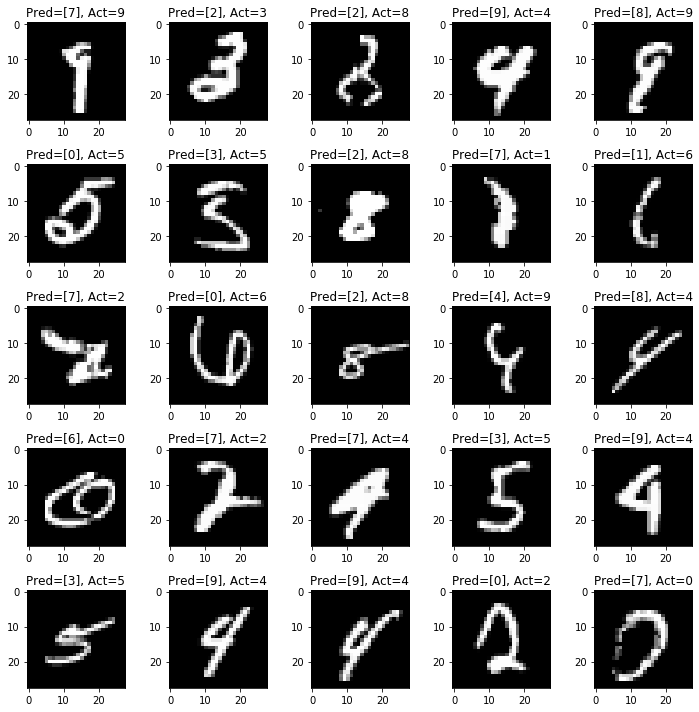

In [0]:
with_L2()

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Epoch=0 Loss=0.1486988514661789 Batch_id=468 Accuracy=87.94: 100%|██████████| 469/469 [00:12<00:00, 36.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0834, Accuracy: 9815/10000 (98.15%)

EPOCH: 1


Epoch=1 Loss=0.10162429511547089 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:13<00:00, 33.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0679, Accuracy: 9831/10000 (98.31%)

EPOCH: 2


Epoch=2 Loss=0.08892179280519485 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:12<00:00, 36.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0588, Accuracy: 9873/10000 (98.73%)

EPOCH: 3


Epoch=3 Loss=0.09244506061077118 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:13<00:00, 35.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0517, Accuracy: 9889/10000 (98.89%)

EPOCH: 4


Epoch=4 Loss=0.09816967695951462 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:12<00:00, 43.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0538, Accuracy: 9884/10000 (98.84%)

EPOCH: 5


Epoch=5 Loss=0.07326873391866684 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:13<00:00, 34.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0601, Accuracy: 9867/10000 (98.67%)

EPOCH: 6


Epoch=6 Loss=0.08618248254060745 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:12<00:00, 42.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0580, Accuracy: 9879/10000 (98.79%)

EPOCH: 7


Epoch=7 Loss=0.12581592798233032 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:13<00:00, 35.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0605, Accuracy: 9866/10000 (98.66%)

EPOCH: 8


Epoch=8 Loss=0.04579662159085274 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:13<00:00, 35.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0526, Accuracy: 9890/10000 (98.90%)

EPOCH: 9


Epoch=9 Loss=0.05873756855726242 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:13<00:00, 34.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0668, Accuracy: 9864/10000 (98.64%)

EPOCH: 10


Epoch=10 Loss=0.06807786971330643 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:12<00:00, 36.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9891/10000 (98.91%)

EPOCH: 11


Epoch=11 Loss=0.08938471227884293 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:13<00:00, 38.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0562, Accuracy: 9907/10000 (99.07%)

EPOCH: 12


Epoch=12 Loss=0.0602618083357811 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:14<00:00, 33.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0578, Accuracy: 9887/10000 (98.87%)

EPOCH: 13


Epoch=13 Loss=0.07258136570453644 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:14<00:00, 31.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0540, Accuracy: 9881/10000 (98.81%)

EPOCH: 14


Epoch=14 Loss=0.08502017706632614 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:14<00:00, 32.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0679, Accuracy: 9856/10000 (98.56%)

EPOCH: 15


Epoch=15 Loss=0.13981148600578308 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:14<00:00, 32.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0785, Accuracy: 9808/10000 (98.08%)

EPOCH: 16


Epoch=16 Loss=0.057381242513656616 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:14<00:00, 40.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9899/10000 (98.99%)

EPOCH: 17


Epoch=17 Loss=0.057505469769239426 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:14<00:00, 32.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0543, Accuracy: 9883/10000 (98.83%)

EPOCH: 18


Epoch=18 Loss=0.025752311572432518 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:14<00:00, 33.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0570, Accuracy: 9896/10000 (98.96%)

EPOCH: 19


Epoch=19 Loss=0.11307751387357712 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:14<00:00, 40.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0433, Accuracy: 9914/10000 (99.14%)

EPOCH: 20


Epoch=20 Loss=0.0626891478896141 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:15<00:00, 30.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0605, Accuracy: 9856/10000 (98.56%)

EPOCH: 21


Epoch=21 Loss=0.13595083355903625 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:14<00:00, 33.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0421, Accuracy: 9909/10000 (99.09%)

EPOCH: 22


Epoch=22 Loss=0.04755319654941559 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:13<00:00, 33.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0758, Accuracy: 9850/10000 (98.50%)

EPOCH: 23


Epoch=23 Loss=0.06355445832014084 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:13<00:00, 34.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0627, Accuracy: 9858/10000 (98.58%)

EPOCH: 24


Epoch=24 Loss=0.05411297082901001 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:13<00:00, 34.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0766, Accuracy: 9823/10000 (98.23%)

EPOCH: 25


Epoch=25 Loss=0.08760036528110504 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:12<00:00, 41.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0588, Accuracy: 9887/10000 (98.87%)

EPOCH: 26


Epoch=26 Loss=0.045910969376564026 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:13<00:00, 35.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0532, Accuracy: 9881/10000 (98.81%)

EPOCH: 27


Epoch=27 Loss=0.11932790279388428 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:13<00:00, 35.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0563, Accuracy: 9895/10000 (98.95%)

EPOCH: 28


Epoch=28 Loss=0.09177175909280777 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:13<00:00, 34.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9907/10000 (99.07%)

EPOCH: 29


Epoch=29 Loss=0.058892130851745605 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 35.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0691, Accuracy: 9833/10000 (98.33%)

EPOCH: 30


Epoch=30 Loss=0.03392304852604866 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:13<00:00, 35.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 9891/10000 (98.91%)

EPOCH: 31


Epoch=31 Loss=0.07328074425458908 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:13<00:00, 35.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0426, Accuracy: 9915/10000 (99.15%)

EPOCH: 32


Epoch=32 Loss=0.0743986964225769 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:13<00:00, 34.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0546, Accuracy: 9906/10000 (99.06%)

EPOCH: 33


Epoch=33 Loss=0.07923664897680283 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:13<00:00, 35.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9911/10000 (99.11%)

EPOCH: 34


Epoch=34 Loss=0.07327332347631454 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:13<00:00, 34.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0616, Accuracy: 9868/10000 (98.68%)

EPOCH: 35


Epoch=35 Loss=0.07149019837379456 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 35.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0663, Accuracy: 9848/10000 (98.48%)

EPOCH: 36


Epoch=36 Loss=0.039289988577365875 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:13<00:00, 45.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0482, Accuracy: 9902/10000 (99.02%)

EPOCH: 37


Epoch=37 Loss=0.05257562920451164 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:13<00:00, 35.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0602, Accuracy: 9869/10000 (98.69%)

EPOCH: 38


Epoch=38 Loss=0.11154089123010635 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:13<00:00, 35.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0454, Accuracy: 9911/10000 (99.11%)

EPOCH: 39


Epoch=39 Loss=0.03683806583285332 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:13<00:00, 34.55it/s]



Test set: Average loss: 0.0466, Accuracy: 9904/10000 (99.04%)



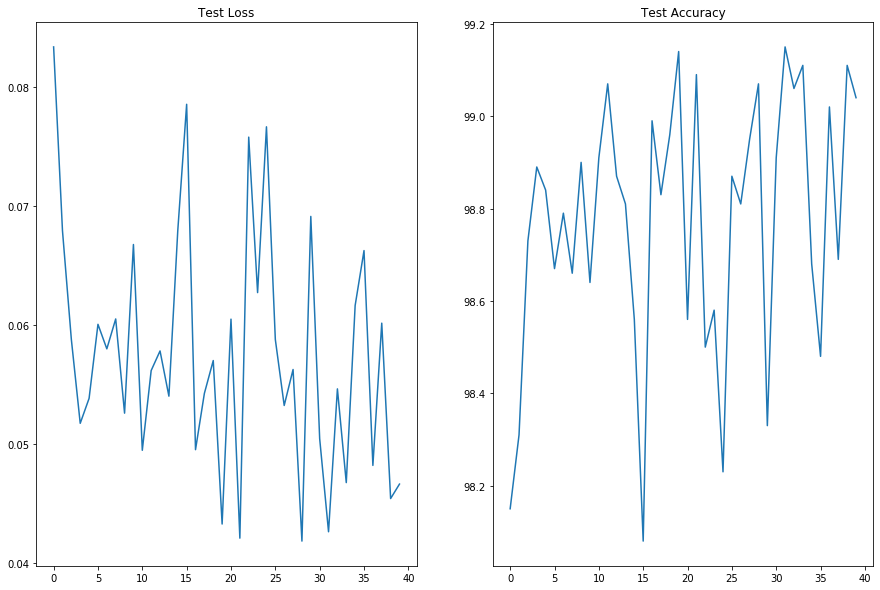

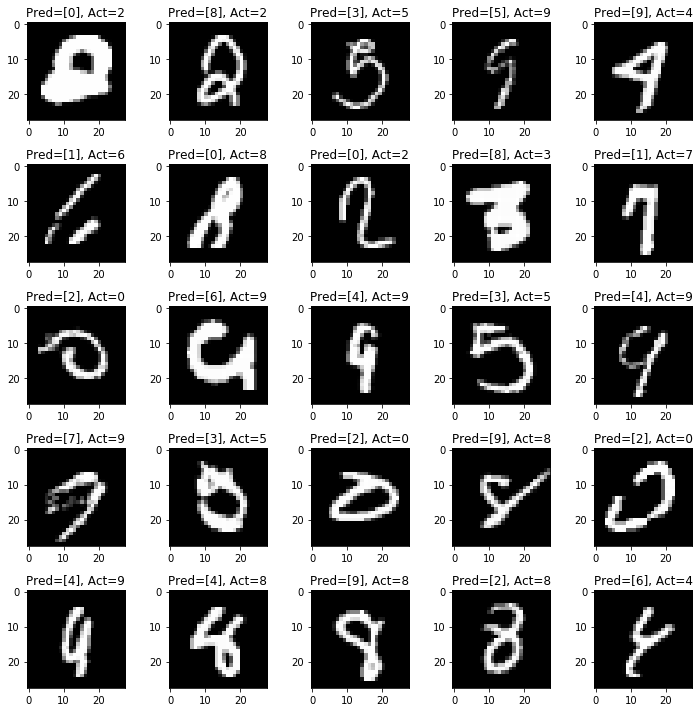

In [0]:
with_L1_L2()

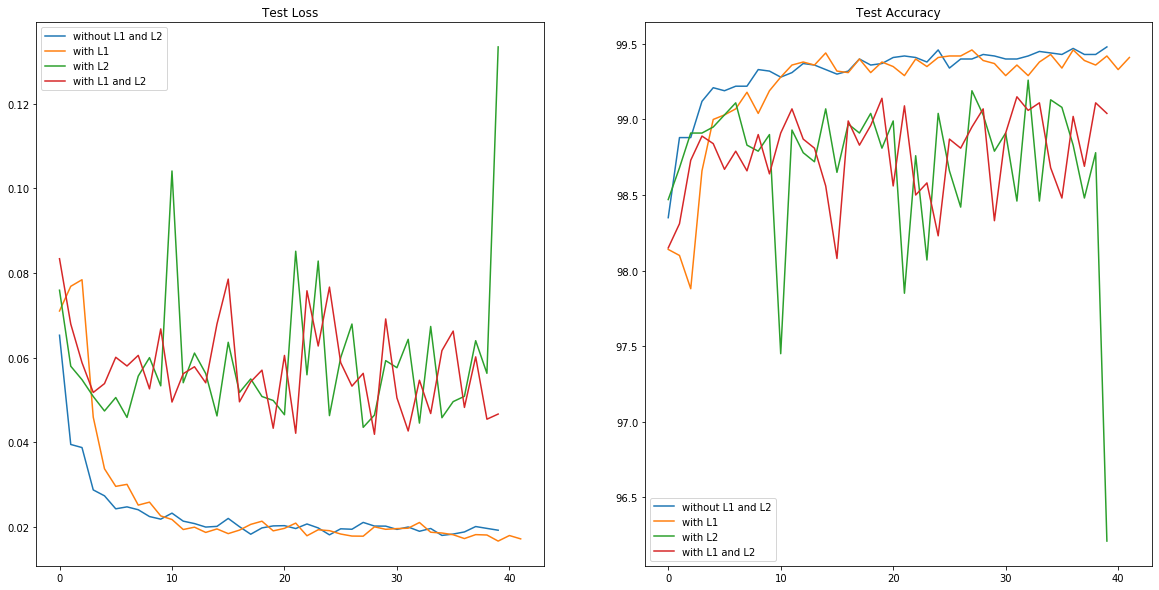

In [0]:
fig, axs = plt.subplots(1,2, figsize=(20,10))
axs[0].plot(test_without_L1L2_Loss, label='without L1 and L2')
axs[0].plot(test_with_L1_Loss, label='with L1 ')
axs[0].plot(test_with_L2_Loss, label='with L2 ')
axs[0].plot(test_with_L1L2_Loss, label='with L1 and L2 ')
axs[0].set_title("Test Loss")
axs[0].legend()
axs[1].plot(test_without_L1L2_acc, label='without L1 and L2')
axs[1].plot(test_with_L1_acc, label='with L1 ')
axs[1].plot(test_with_L2_acc, label='with L2')
axs[1].plot(test_with_L1L2_acc, label='with L1 and L2 ')
axs[1].set_title("Test Accuracy")
axs[1].legend()

In [0]:
from google.colab import files
from google.colab import drive

drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# This displaye from Google Drive after mounting entetring authorization code
!ls "/content/drive/My Drive/"


In [0]:
import matplotlib.pyplot as plt
from google.colab import files
def save_misclassified(misclassified):
  fig = plt.figure(figsize = (10,10))
  for i in range(25):
        sub = fig.add_subplot(5, 5, i+1)
        plt.savefig(i+'.png')
        files.download(i+'.png')